In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

import zipfile

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/dataset/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define paths
train_dir = "dataset/train"
test_dir = "dataset/test"

# Parameters
batch_size = 64
img_height = 48
img_width = 48

# Load train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

# Normalize the pixel values
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [ ]:
def dual_path_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Main path
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Residual path
    residual = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(inputs)
    residual = layers.BatchNormalization()(residual)
    residual = layers.MaxPooling2D((2, 2))(residual)  # Apply max pooling to match dimensions

    # Combine paths
    combined = layers.Add()([x, residual])
    combined = layers.ReLU()(combined)

    # Further layers
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

input_shape = (img_height, img_width, 1)  # Grayscale images
num_classes = 7
model = dual_path_cnn(input_shape, num_classes)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=50,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

# Save the model in the native Keras format
model.save('fer_ducnn_model.keras')

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 593s 1s/step - accuracy: 0.2284 - loss: 2.4640 - val_accuracy: 0.2609 - val_loss: 3.7823
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 650s 1s/step - accuracy: 0.2555 - loss: 1.7754 - val_accuracy: 0.2634 - val_loss: 1.8083
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 613s 1s/step - accuracy: 0.2629 - loss: 1.7345 - val_accuracy: 0.3034 - val_loss: 1.6674
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.2699 - loss: 1.7105 - val_accuracy: 0.2707 - val_loss: 1.7241
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 596s 1s/step - accuracy: 0.2798 - loss: 1.6807 - val_accuracy: 0.3175 - val_loss: 1.6434
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.2887 - loss: 1.6667 - val_accuracy: 0.2947 - val_loss: 1.6888
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.2920 - loss: 1.6574 - val_accuracy: 0.3066 - val_loss: 1.6711
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 603s 1s/step - accuracy: 0.3019 - loss: 1.6393 - val_accu

113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 232ms/step - accuracy: 0.2669 - loss: 1.6335
Validation accuracy: 0.45


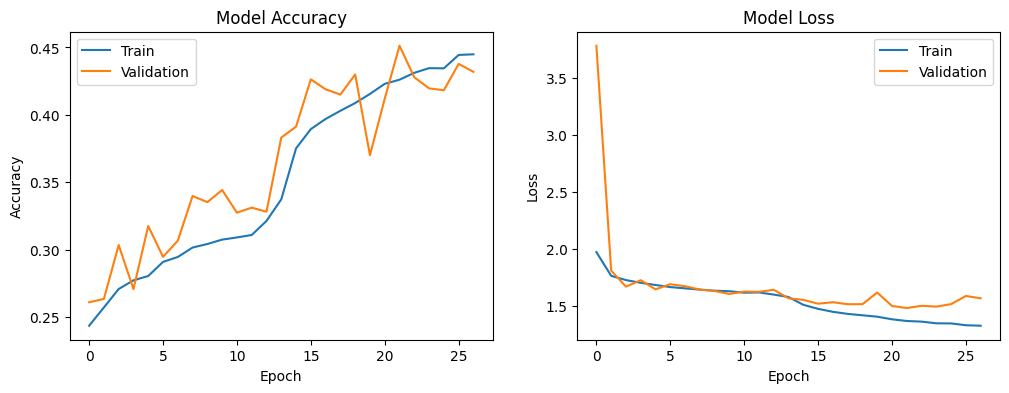

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(test_ds)
print(f'Validation accuracy: {val_accuracy:.2f}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()